In [52]:
import tensorflow as tf
import numpy as np
import os
import re
import tensorflow_hub as hub
#from tensorflow import keras
#from keras.layers import Layer
#from keras import backend as K
#import keras.layers as layers
#from keras.models import Model, load_model
import pandas as pd
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

### Get Data

In [2]:
data = pd.read_csv('dataset/data/articles_dataset.csv')

In [3]:
data.head()

,title,content,link,source,class
0,Tibit Communications Raises $20M in Series B F...,"Tibit Communications, Inc., a Petaluma, CA-bas...",http://www.finsmes.com/2019/04/tibit-communica...,FinsmesUSA,Funding
1,Twitter blames human error after blocking a Ne...,"Over the holiday weekend, The New York Times f...",https://techcrunch.com/2017/11/27/twitter-blam...,techcrunch,Other
2,SimplyCook Raises £4.5M in Series A Funding\n,"SimplyCook, a London, UK-based recipe kit serv...",http://www.finsmes.com/2019/01/simplycook-rais...,FinsmesUK,Funding
3,Moogsoft Secures $40M in Series D Funding\n,"Moogsoft, a San Francisco, CA-based provider o...",http://www.finsmes.com/2018/03/moogsoft-secure...,FinsmesUSA,Funding
4,Zeta Global acquires commenting service†Disqus,A source close to the two companies tells us t...,https://techcrunch.com/2017/12/05/zeta-global-...,techcrunch,Other


In [4]:
data.loc[4, 'content']

'A source close to the two companies tells us that the acquisition price was close to $90 million. This marks Zeta’s eleventh acquisition since it was founded in 2007. Zeta Global’s acquisitions have typically focused on more fundamental technologies like AI and machine learning, customer lifecycle management and other adtech related services. At first glance, Disqus doesn’t quite seem to fit into this list, but Disqus sits on a huge data set that goes beyond your favorite troll’s political comments. “Marketers typically have to make trade-offs between reaching engaged audiences on social platforms with massive reach and using tools that give them control and access to granular targeting capabilities,” said Zeta Global CEO, chairman and co-founder David A. Steinberg. “Disqus strengthens Zeta’s ability to offer the best of both worlds with the scale, visibility and performance marketers have been asking for.” Disqus gives these marketers the ability to target users based on their intere

In [5]:
def preprocess_content(content):
    content = content.lower()
    links_regex = re.compile('(https?:\/\/|www|ftp)[\w\./\?\=+&-]+')
    money_regex = re.compile('USD\s?\d+[,\d]+|\$\s?\d+[,\d]+|GBP\s?\d+[,\d]+|£\s?\d+[,\d]+|EUR\s?\d+[,\d]+|€\s?\d+[,\d]+', flags=re.IGNORECASE)
    digits_regex = re.compile('\d+[,.\d]+')
    white_space_regex = re.compile('\s+')
    
    content = re.sub(links_regex, 'LINK',  content)
    content = re.sub(money_regex, 'MONEY', content)
    content = re.sub(digits_regex, 'NUMBER', content)
    content = re.sub(white_space_regex, ' ', content)
    
    return content

In [6]:
data.shape

(45013, 5)

In [7]:
data = data[~data['content'].isnull()]

In [8]:
data['class'].value_counts()

Other      22868
Funding    21163
Name: class, dtype: int64

In [9]:
data['content'] = data['content'].map(preprocess_content)

In [11]:
articles = data['content'].values
titles = data['title'].values
labels = data['class'].values

#### Encode labels

In [12]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


def encode_labels(labels):
    encoded = label_encoder.transform(labels)
    return encoded

def decode_labels(encoded_labels):
    labels_type = type(encoded_labels)
    
    if labels_type == int:
        try:
            label = label_encoder.inverse_transform([encoded_labels])
        except ValueError:
            print('Unknown value')
            return np.nan
        
        return label
    
    elif hasattr(encoded_labels, '__iter__') and labels_type != str:
        try:
            labels = label_encoder.inverse_transform(encoded_labels)
            
        except ValueError:
            print('Unknown value')
            raise
            
        return labels
    else:
        raise TypeError

In [13]:
tf.test.is_gpu_available()

True

### Use TensorFlow Keras and CNN

In [14]:
shuffle = np.random.permutation(len(articles))
articles = articles[shuffle]
titles = titles[shuffle]
labels = labels[shuffle]

In [15]:
len(articles)

44031

In [16]:
data_size = len(articles)

train_size = round(0.8 * data_size)
dev_size = round(0.1 * data_size)

dev_end = train_size + dev_size

print(train_size, dev_size, dev_end)

35225 4403 39628


In [17]:
articles_train, labels_train, titles_train = articles[:train_size], labels[:train_size], titles[:train_size]
articles_dev, labels_dev, titles_dev = articles[train_size:dev_end], labels[train_size:dev_end], titles[train_size:dev_end]
articles_test, labels_test, titles_test = articles[dev_end:], labels[dev_end:], titles[dev_end:]

### Preprocess the text for use with the CNN

In [18]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(articles_train)

X_train = tokenizer.texts_to_sequences(articles_train)
X_dev = tokenizer.texts_to_sequences(articles_dev)
X_test = tokenizer.texts_to_sequences(articles_test)

vocab_size = len(tokenizer.word_index) + 1

vocab_size

156764

In [19]:
maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_dev = pad_sequences(X_dev, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Run CNN models 

#### Function to plot the history of models

In [20]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

#### Function to Build Model

In [21]:
def build_model(vocab_size, embedding_dim, max_len, trainable_emb=True,  embeddings=None, dropout_rate=0.1):
    model = Sequential()
    
    if type(embeddings) is np.ndarray:
        model.add(layers.Embedding(vocab_size, embedding_dim, 
                                   weights=[embedding_matrix], 
                                   input_length=max_len, 
                                   trainable=trainable_emb))
    else:
        model.add(layers.Embedding(vocab_size, embedding_dim, 
                                   input_length=max_len, 
                                   trainable=trainable_emb))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [22]:
model = build_model(vocab_size, embedding_dim=100, max_len=300)
model.summary()

W0802 12:57:01.828403 140051476551488 deprecation.py:506] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0802 12:57:01.930777 140051476551488 deprecation.py:506] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0802 12:57:02.184091 140051476551488 deprecation.py:323] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          15676400  
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 15,741,829
Trainable params: 15,741,829
Non-trainable params: 0
____________________________________________

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 21s 599us/sample - loss: 0.2751 - acc: 0.8876 - val_loss: 0.2216 - val_acc: 0.9101
Epoch 2/10
35225/35225 [==============================] - 18s 525us/sample - loss: 0.2054 - acc: 0.9194 - val_loss: 0.2181 - val_acc: 0.9148
Epoch 3/10
35225/35225 [==============================] - 19s 530us/sample - loss: 0.1489 - acc: 0.9463 - val_loss: 0.2677 - val_acc: 0.9123
Epoch 4/10
35225/35225 [==============================] - 18s 519us/sample - loss: 0.0996 - acc: 0.9651 - val_loss: 0.2944 - val_acc: 0.8996
Epoch 5/10
35225/35225 [==============================] - 18s 524us/sample - loss: 0.0649 - acc: 0.9781 - val_loss: 0.3410 - val_acc: 0.9028
Epoch 6/10
35225/35225 [==============================] - 18s 520us/sample - loss: 0.0478 - acc: 0.9834 - val_loss: 0.3900 - val_acc: 0.9080
Epoch 7/10
35225/35225 [==============================] - 18s 520us/sample - loss: 0.0340 - acc: 0.9876 -

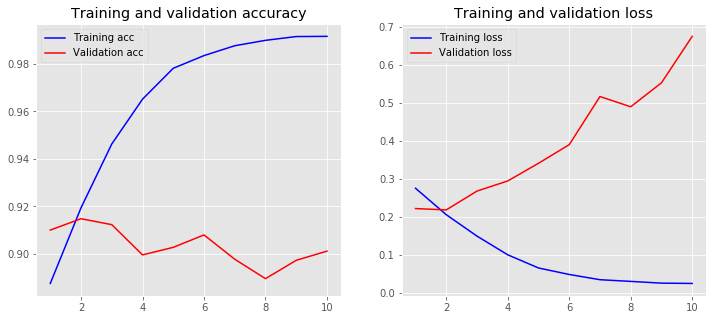

In [27]:
history = model.fit(X_train, labels_train,
                    epochs=10,
                    #verbose=False,
                    validation_data=(X_dev, labels_dev),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_dev, labels_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

#### Using Glove embeddings

In [25]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [29]:
embedding_dim = 100
max_len = 300

embedding_matrix = create_embedding_matrix('embeddings/glove/glove.6B.100d.txt', 
                                           tokenizer.word_index, embedding_dim)

In [30]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.4875162664897553

In [31]:
model = build_model(vocab_size, embedding_dim=embedding_dim, max_len=max_len, embeddings=embedding_matrix)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          15676400  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 15,741,829
Trainable params: 15,741,829
Non-trainable params: 0
__________________________________________

In [32]:
model.reset_states()
history = model.fit(X_train, labels_train,
                    epochs=30,
                    #verbose=False,
                    validation_data=(X_dev, labels_dev),
                    batch_size=10, callbacks=[early_stop])
loss, accuracy = model.evaluate(X_train, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_dev, labels_dev, verbose=False)
print("Dev Accuracy:  {:.4f}".format(accuracy))

Train on 35225 samples, validate on 4403 samples
Epoch 1/30
35225/35225 [==============================] - 40s 1ms/sample - loss: 0.2898 - acc: 0.8802 - val_loss: 0.2317 - val_acc: 0.9053
Epoch 2/30
35225/35225 [==============================] - 22s 635us/sample - loss: 0.2230 - acc: 0.9134 - val_loss: 0.2170 - val_acc: 0.9137
Epoch 3/30
35225/35225 [==============================] - 22s 625us/sample - loss: 0.1808 - acc: 0.9300 - val_loss: 0.2205 - val_acc: 0.9160
Epoch 4/30
35225/35225 [==============================] - 22s 612us/sample - loss: 0.1287 - acc: 0.9517 - val_loss: 0.3655 - val_acc: 0.8964
Epoch 5/30
35225/35225 [==============================] - 21s 607us/sample - loss: 0.0804 - acc: 0.9696 - val_loss: 0.3341 - val_acc: 0.9087
Epoch 6/30
35225/35225 [==============================] - 22s 610us/sample - loss: 0.0540 - acc: 0.9796 - val_loss: 0.5162 - val_acc: 0.8969
Epoch 7/30
35225/35225 [==============================] - 21s 603us/sample - loss: 0.0413 - acc: 0.9846 - v

In [33]:
loss, accuracy = model.evaluate(X_test, labels_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

Test Accuracy: 0.8958


### More complex CNN Model

In [34]:
epochs = 20
embedding_dim = 100
num_filters = 128
kernel_sizes = [2, 3, 5]
dense_layer_dims = [20,30,10]
dropout_rate = 0.1

def build_cnn_model(kernel_sizes, dense_layer_dims, vocab_size, embedding_dim=50, embedding_matrix=None, trainable=False, max_len=300, dropout_rate=0.1, num_filters=128):
    wordids = layers.Input(shape=(max_len, ))
    
    if type(embedding_matrix) == np.ndarray:
        emb = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=trainable)(wordids)
    else:
        emb = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, trainable=trainable)(wordids)
    
    conv_layers_list = []
    
    for kernel_size in kernel_sizes:
        conv_layer = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(emb)
        conv_layer = layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_list.append(conv_layer)
        
    concat_layer = layers.concatenate(conv_layers_list, axis=1)
    dense_layer = layers.Dropout(rate=dropout_rate)(concat_layer)
    
    for dense_size in dense_layer_dims:
        dense_layer = layers.Dense(dense_size, activation='relu')(dense_layer)
    
    prediction = layers.Dense(4, activation='softmax')(dense_layer)
    
    model = Model(inputs=wordids, outputs=prediction)
    model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return model

In [35]:
model = build_cnn_model(kernel_sizes, dense_layer_dims, vocab_size)
history = model.fit(X_train, labels_train,
                    epochs=40,
                    #verbose=False,
                    validation_data=(X_dev, labels_dev),
                    batch_size=10, callbacks=[early_stop])
loss, accuracy = model.evaluate(X_train, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_dev, labels_dev, verbose=False)
print("Dev Accuracy:  {:.4f}".format(accuracy))

Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 18s 511us/sample - loss: 0.4182 - acc: 0.8006 - val_loss: 0.2611 - val_acc: 0.8937
Epoch 2/40
35225/35225 [==============================] - 18s 498us/sample - loss: 0.2576 - acc: 0.8973 - val_loss: 0.2558 - val_acc: 0.8994
Epoch 3/40
35225/35225 [==============================] - 17s 495us/sample - loss: 0.2332 - acc: 0.9073 - val_loss: 0.2514 - val_acc: 0.9032
Epoch 4/40
35225/35225 [==============================] - 18s 502us/sample - loss: 0.2107 - acc: 0.9153 - val_loss: 0.2298 - val_acc: 0.9101
Epoch 5/40
35225/35225 [==============================] - 17s 493us/sample - loss: 0.1836 - acc: 0.9291 - val_loss: 0.2307 - val_acc: 0.9114
Epoch 6/40
35225/35225 [==============================] - 17s 496us/sample - loss: 0.1534 - acc: 0.9404 - val_loss: 0.2548 - val_acc: 0.8983
Epoch 7/40
35225/35225 [==============================] - 17s 497us/sample - loss: 0.1299 - acc: 0.9511 -

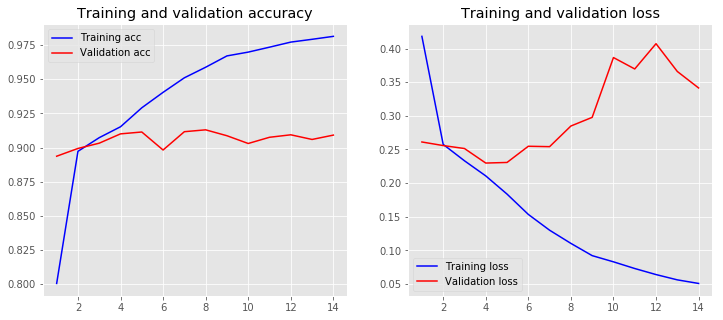

In [36]:
plot_history(history)

In [37]:
loss, accuracy = model.evaluate(X_test, labels_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

Test Accuracy: 0.8948


#### With Glove embeddings

In [39]:
model = build_cnn_model(kernel_sizes, dense_layer_dims, vocab_size, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix)
history = model.fit(X_train, labels_train,
                    epochs=40,
                    #verbose=False,
                    validation_data=(X_dev, labels_dev),
                    batch_size=10, callbacks=[early_stop])
loss, accuracy = model.evaluate(X_train, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_dev, labels_dev, verbose=False)
print("Dev Accuracy:  {:.4f}".format(accuracy))

Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 18s 503us/sample - loss: 0.3130 - acc: 0.8706 - val_loss: 0.2309 - val_acc: 0.9048
Epoch 2/40
35225/35225 [==============================] - 17s 495us/sample - loss: 0.2414 - acc: 0.9050 - val_loss: 0.2306 - val_acc: 0.9062
Epoch 3/40
35225/35225 [==============================] - 18s 504us/sample - loss: 0.2149 - acc: 0.9157 - val_loss: 0.2192 - val_acc: 0.9085
Epoch 4/40
35225/35225 [==============================] - 17s 493us/sample - loss: 0.1823 - acc: 0.9304 - val_loss: 0.2278 - val_acc: 0.9073
Epoch 5/40
35225/35225 [==============================] - 18s 499us/sample - loss: 0.1485 - acc: 0.9451 - val_loss: 0.2620 - val_acc: 0.9080
Epoch 6/40
35225/35225 [==============================] - 18s 498us/sample - loss: 0.1236 - acc: 0.9559 - val_loss: 0.2969 - val_acc: 0.8937
Epoch 7/40
35225/35225 [==============================] - 17s 493us/sample - loss: 0.0990 - acc: 0.9655 -

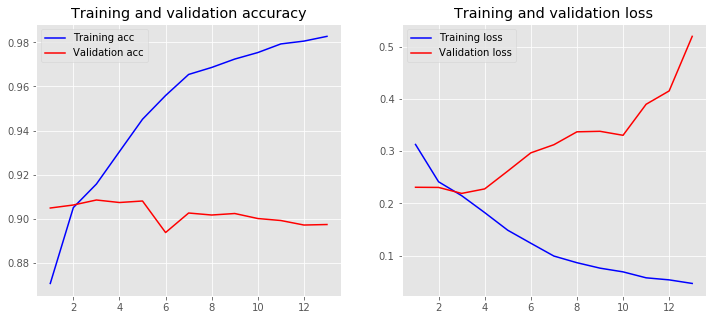

In [40]:
plot_history(history)

In [41]:
loss, accuracy = model.evaluate(X_test, labels_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

Test Accuracy: 0.8910


In [48]:
model.save('models/CNN/CNN_cmplx_glove.h5')

In [49]:
import pickle
tokenizer_pickle = open('CNN_glove_tokenizer.pkl', 'wb')
pickle.dump(tokenizer, tokenizer_pickle)
tokenizer_pickle.close()

#### Change length of sentence to 100 tokens

In [50]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(articles_train)

X_train100 = tokenizer.texts_to_sequences(articles_train)
X_dev100 = tokenizer.texts_to_sequences(articles_dev)
X_test100 = tokenizer.texts_to_sequences(articles_test)

vocab_size100 = len(tokenizer.word_index) + 1

vocab_size100

maxlen100 = 100

X_train100 = pad_sequences(X_train100, padding='post', maxlen=maxlen100)
X_dev100 = pad_sequences(X_dev100, padding='post', maxlen=maxlen100)
X_test100 = pad_sequences(X_test100, padding='post', maxlen=maxlen100)

In [51]:
model = build_cnn_model(kernel_sizes, dense_layer_dims, vocab_size, max_len=maxlen100)
history = model.fit(X_train100, labels_train,
                    epochs=20,
                    #verbose=False,
                    validation_data=(X_dev100, labels_dev),
                    batch_size=10, callbacks=[early_stop])
loss, accuracy = model.evaluate(X_train100, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_dev100, labels_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 35225 samples, validate on 4403 samples
Epoch 1/20
35225/35225 [==============================] - 16s 463us/sample - loss: 0.4860 - acc: 0.7733 - val_loss: 0.4162 - val_acc: 0.8183
Epoch 2/20
35225/35225 [==============================] - 16s 447us/sample - loss: 0.3915 - acc: 0.8289 - val_loss: 0.3909 - val_acc: 0.8263
Epoch 3/20
35225/35225 [==============================] - 16s 445us/sample - loss: 0.3494 - acc: 0.8508 - val_loss: 0.3804 - val_acc: 0.8431
Epoch 4/20
35225/35225 [==============================] - 15s 435us/sample - loss: 0.3009 - acc: 0.8765 - val_loss: 0.3938 - val_acc: 0.8358
Epoch 5/20
35225/35225 [==============================] - 15s 433us/sample - loss: 0.2504 - acc: 0.8993 - val_loss: 0.4514 - val_acc: 0.8242
Epoch 6/20
35225/35225 [==============================] - 15s 435us/sample - loss: 0.2099 - acc: 0.9177 - val_loss: 0.4793 - val_acc: 0.8267
Epoch 7/20
35225/35225 [==============================] - 15s 412us/sample - loss: 0.1758 - acc: 0.9330 -

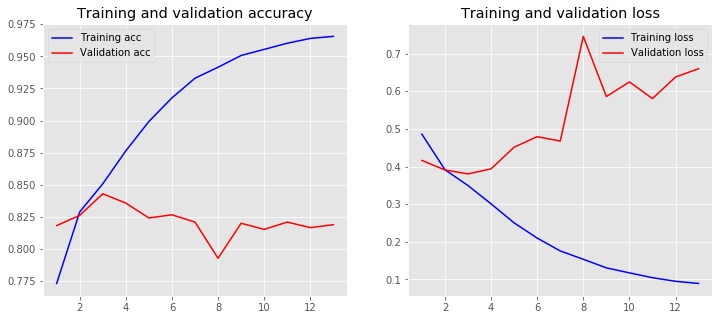

In [52]:
plot_history(history)

### Hyperparmeter Tuning with complex CNN

In [60]:
number_of_trials = 30

filter_list = [64, 128]
kernel_sizes_list = [2,3,4,5]
dense_layer_dims_list = [10,20,30,40, 50, 60, 100, 64, 128, 256]
dropout_rates_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

best_val_accuracy = 0
best_parameters = {}

for trial in range(number_of_trials):
    
    num_filters = random.choice(filter_list)
    kernel_sizes = random.choices(kernel_sizes_list, k=3)
    number_dense_layers = random.choice([1,2,3])
    dense_layer_dims = random.choices(dense_layer_dims_list, k=number_dense_layers)
    dropout_rate = random.choice(dropout_rates_list)
    
    model = build_cnn_model(kernel_sizes, dense_layer_dims, vocab_size, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix, dropout_rate=dropout_rate, num_filters=num_filters)
    history = model.fit(X_train, labels_train,
                    epochs=40,
                    #verbose=False,
                    validation_data=(X_dev, labels_dev),
                    batch_size=128, callbacks=[early_stop])
    
    dev_loss, dev_accuracy = model.evaluate(X_dev, labels_dev, verbose=False)
    print("Dev Accuracy:  {:.4f} for num_filters={}, kernel_sizes={}, dense_layer_dims={}, dropout_rate={}".format(dev_accuracy, num_filters, kernel_sizes, dense_layer_dims, dropout_rate))
    
    if dev_accuracy > best_val_accuracy:
        best_val_accuracy = dev_accuracy
        
        best_parameters['num_filters'] = num_filters
        best_parameters['kernel_sizes'] = kernel_sizes
        best_parameters['dense_layer_dims'] = dense_layer_dims
        best_parameters['dropout_rate'] = dropout_rate

print('The best accuracy is: {}'.format(best_val_accuracy))

Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 19s 527us/sample - loss: 0.3254 - acc: 0.8626 - val_loss: 0.2528 - val_acc: 0.9007
Epoch 2/40
35225/35225 [==============================] - 18s 514us/sample - loss: 0.2599 - acc: 0.8955 - val_loss: 0.2372 - val_acc: 0.9007
Epoch 3/40
35225/35225 [==============================] - 17s 492us/sample - loss: 0.2400 - acc: 0.9033 - val_loss: 0.2174 - val_acc: 0.9126
Epoch 4/40
35225/35225 [==============================] - 18s 504us/sample - loss: 0.2231 - acc: 0.9109 - val_loss: 0.2315 - val_acc: 0.9130
Epoch 5/40
35225/35225 [==============================] - 18s 504us/sample - loss: 0.2068 - acc: 0.9162 - val_loss: 0.2255 - val_acc: 0.9171
Epoch 6/40
35225/35225 [==============================] - 17s 487us/sample - loss: 0.1904 - acc: 0.9241 - val_loss: 0.2244 - val_acc: 0.9139
Epoch 7/40
35225/35225 [==============================] - 17s 477us/sample - loss: 0.1741 - acc: 0.9302 -

W0802 14:08:35.868582 140051476551488 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 19s 532us/sample - loss: 0.3799 - acc: 0.8373 - val_loss: 0.2664 - val_acc: 0.8944
Epoch 2/40
35225/35225 [==============================] - 18s 503us/sample - loss: 0.3008 - acc: 0.8788 - val_loss: 0.2460 - val_acc: 0.8967
Epoch 3/40
35225/35225 [==============================] - 18s 506us/sample - loss: 0.2833 - acc: 0.8851 - val_loss: 0.2481 - val_acc: 0.9005
Epoch 4/40
35225/35225 [==============================] - 18s 504us/sample - loss: 0.2709 - acc: 0.8898 - val_loss: 0.2382 - val_acc: 0.9019
Epoch 5/40
35225/35225 [==============================] - 17s 496us/sample - loss: 0.2607 - acc: 0.8956 - val_loss: 0.2334 - val_acc: 0.9078
Epoch 6/40
35225/35225 [==============================] - 18s 502us/sample - loss: 0.2537 - acc: 0.8981 - val_loss: 0.2263 - val_acc: 0.9089
Epoch 7/40
35225/35225 [==============================] - 18s 508us/sample - loss: 0.2474 - acc: 0.9028 -

W0802 14:16:55.514868 140051476551488 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 20s 555us/sample - loss: 0.3857 - acc: 0.8285 - val_loss: 0.2589 - val_acc: 0.8914
Epoch 2/40
35225/35225 [==============================] - 18s 513us/sample - loss: 0.3084 - acc: 0.8727 - val_loss: 0.2577 - val_acc: 0.8971
Epoch 3/40
35225/35225 [==============================] - 18s 524us/sample - loss: 0.2897 - acc: 0.8830 - val_loss: 0.2738 - val_acc: 0.9001
Epoch 4/40
35225/35225 [==============================] - 19s 533us/sample - loss: 0.2816 - acc: 0.8869 - val_loss: 0.2442 - val_acc: 0.8980
Epoch 5/40
35225/35225 [==============================] - 18s 518us/sample - loss: 0.2719 - acc: 0.8908 - val_loss: 0.2463 - val_acc: 0.8998
Epoch 6/40
35225/35225 [==============================] - 18s 516us/sample - loss: 0.2660 - acc: 0.8915 - val_loss: 0.2560 - val_acc: 0.9048
Epoch 7/40
35225/35225 [==============================] - 18s 524us/sample - loss: 0.2626 - acc: 0.8943 -

W0802 14:28:24.967496 140051476551488 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 20s 575us/sample - loss: 0.4065 - acc: 0.8163 - val_loss: 0.2938 - val_acc: 0.8839
Epoch 2/40
35225/35225 [==============================] - 19s 547us/sample - loss: 0.3170 - acc: 0.8700 - val_loss: 0.2744 - val_acc: 0.8908
Epoch 3/40
35225/35225 [==============================] - 20s 580us/sample - loss: 0.2889 - acc: 0.8820 - val_loss: 0.2708 - val_acc: 0.9019
Epoch 5/40
35225/35225 [==============================] - 21s 590us/sample - loss: 0.2794 - acc: 0.8870 - val_loss: 0.2390 - val_acc: 0.9019
Epoch 6/40
35225/35225 [==============================] - 20s 570us/sample - loss: 0.2732 - acc: 0.8892 - val_loss: 0.2529 - val_acc: 0.9012
Epoch 7/40
35225/35225 [==============================] - 20s 560us/sample - loss: 0.2682 - acc: 0.8920 - val_loss: 0.2713 - val_acc: 0.9042
Epoch 8/40
35225/35225 [==============================] - 20s 562us/sample - loss: 0.2642 - acc: 0.8929 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35225/35225 [==============================] - 19s 550us/sample - loss: 0.2408 - acc: 0.9029 - val_loss: 0.2703 - val_acc: 0.9080
Epoch 16/40
35225/35225 [==============================] - 19s 541us/sample - loss: 0.2371 - acc: 0.9034 - val_loss: 0.2538 - val_acc: 0.9114
Epoch 17/40
35225/35225 [==============================] - 19s 548us/sample - loss: 0.2342 - acc: 0.9056 - val_loss: 0.2593 - val_acc: 0.9062
Epoch 18/40
35225/35225 [==============================] - 19s 538us/sample - loss: 0.2353 - acc: 0.9026 - val_loss: 0.2788 - val_acc: 0.9112
Epoch 19/40
35225/35225 [==============================] - 24s 669us/sample - loss: 0.2775 - acc: 0.8888 - val_loss: 0.2316 - val_acc: 0.9073
Epoch 4/40
35225/35225 [==============================] - 22s 622us/sample - loss: 0.2640 - acc: 0.8933 - val_loss: 0.2493 - val_acc: 0.9053
Epoch 5/40
35225/35225 [==============================] - 20s 567us/sample - loss: 0.2593 - acc: 0.8942 - val_loss: 0.2371 - val_acc: 0.9105
Epoch 6/40
35225/352

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35225/35225 [==============================] - 20s 580us/sample - loss: 0.2262 - acc: 0.9072 - val_loss: 0.2218 - val_acc: 0.9112
Epoch 24/40
35225/35225 [==============================] - 21s 584us/sample - loss: 0.2263 - acc: 0.9084 - val_loss: 0.2199 - val_acc: 0.9132
Epoch 25/40
35225/35225 [==============================] - 21s 606us/sample - loss: 0.2232 - acc: 0.9100 - val_loss: 0.2223 - val_acc: 0.9128
Epoch 26/40
35225/35225 [==============================] - 20s 574us/sample - loss: 0.2247 - acc: 0.9090 - val_loss: 0.2264 - val_acc: 0.9132
Epoch 27/40
35225/35225 [==============================] - 21s 597us/sample - loss: 0.2254 - acc: 0.9109 - val_loss: 0.2218 - val_acc: 0.9137
Epoch 28/40
35225/35225 [==============================] - 21s 593us/sample - loss: 0.2204 - acc: 0.9117 - val_loss: 0.2330 - val_acc: 0.9132
Epoch 29/40
35225/35225 [==============================] - 20s 580us/sample - loss: 0.2217 - acc: 0.9106 - val_loss: 0.2210 - val_acc: 0.9162
Epoch 00029: early

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35225/35225 [==============================] - 20s 569us/sample - loss: 0.1551 - acc: 0.9405 - val_loss: 0.2156 - val_acc: 0.9221
Epoch 19/40
35225/35225 [==============================] - 21s 594us/sample - loss: 0.1511 - acc: 0.9413 - val_loss: 0.2074 - val_acc: 0.9191
Epoch 00019: early stopping
Dev Accuracy:  0.9191 for num_filters=128, kernel_sizes=[5, 2, 3], dense_layer_dims=[40, 30, 10], dropout_rate=0.6
Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 21s 610us/sample - loss: 0.3013 - acc: 0.8763 - val_loss: 0.2333 - val_acc: 0.9010
Epoch 2/40
35225/35225 [==============================] - 20s 560us/sample - loss: 0.2431 - acc: 0.9026 - val_loss: 0.2284 - val_acc: 0.9107
Epoch 3/40
35225/35225 [==============================] - 20s 561us/sample - loss: 0.2125 - acc: 0.9159 - val_loss: 0.2291 - val_acc: 0.9044
Epoch 4/40
35225/35225 [==============================] - 19s 546us/sample - loss: 0.1828 - acc: 0.9294 - val_los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35225/35225 [==============================] - 20s 556us/sample - loss: 0.0705 - acc: 0.9743 - val_loss: 0.3369 - val_acc: 0.9005
Epoch 11/40
35225/35225 [==============================] - 20s 571us/sample - loss: 0.0604 - acc: 0.9781 - val_loss: 0.4220 - val_acc: 0.9003
Epoch 12/40
35225/35225 [==============================] - 20s 556us/sample - loss: 0.0604 - acc: 0.9775 - val_loss: 0.3772 - val_acc: 0.8969
Epoch 13/40
35225/35225 [==============================] - 21s 592us/sample - loss: 0.0496 - acc: 0.9813 - val_loss: 0.4148 - val_acc: 0.8903
Epoch 14/40
35225/35225 [==============================] - 20s 562us/sample - loss: 0.0440 - acc: 0.9843 - val_loss: 0.4194 - val_acc: 0.8921
Epoch 00014: early stopping
Dev Accuracy:  0.8921 for num_filters=128, kernel_sizes=[3, 3, 4], dense_layer_dims=[10, 10], dropout_rate=0.1
Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 21s 609us/sample - loss: 0.3452 - acc: 0.8560 - val_loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35225/35225 [==============================] - 22s 628us/sample - loss: 0.1003 - acc: 0.9620 - val_loss: 0.3577 - val_acc: 0.9003
Epoch 11/40
35225/35225 [==============================] - 20s 570us/sample - loss: 0.0925 - acc: 0.9643 - val_loss: 0.3439 - val_acc: 0.9042
Epoch 12/40
35225/35225 [==============================] - 20s 571us/sample - loss: 0.0834 - acc: 0.9681 - val_loss: 0.3453 - val_acc: 0.9021
Epoch 13/40
35225/35225 [==============================] - 21s 593us/sample - loss: 0.0736 - acc: 0.9724 - val_loss: 0.4227 - val_acc: 0.9039
Epoch 14/40
35225/35225 [==============================] - 19s 544us/sample - loss: 0.0732 - acc: 0.9722 - val_loss: 0.4062 - val_acc: 0.8960
Epoch 00014: early stopping
Dev Accuracy:  0.8960 for num_filters=64, kernel_sizes=[2, 4, 2], dense_layer_dims=[128], dropout_rate=0.1
Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 28s 801us/sample - loss: 0.3483 - acc: 0.8498 - val_loss: 0.

In [61]:
best_val_accuracy

0.91914606

In [68]:
best_parameters

{'num_filters': 128,
 'kernel_sizes': [5, 2, 3],
 'dense_layer_dims': [40, 30, 10],
 'dropout_rate': 0.6}

### Recreate best model and get Test Accuracy

In [69]:
model = build_cnn_model(best_parameters['kernel_sizes'], best_parameters['dense_layer_dims'], 
                        vocab_size, embedding_dim=embedding_dim, 
                        embedding_matrix=embedding_matrix, 
                        dropout_rate=best_parameters['dropout_rate'], num_filters=best_parameters['num_filters'])

history = model.fit(X_train, labels_train,
                epochs=40,
                #verbose=False,
                validation_data=(X_dev, labels_dev),
                batch_size=128, callbacks=[early_stop])

Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 5s 156us/sample - loss: 0.5300 - acc: 0.7482 - val_loss: 0.2926 - val_acc: 0.8830
Epoch 2/40
35225/35225 [==============================] - 2s 70us/sample - loss: 0.3163 - acc: 0.8722 - val_loss: 0.2571 - val_acc: 0.8948
Epoch 3/40
35225/35225 [==============================] - 3s 71us/sample - loss: 0.2844 - acc: 0.8854 - val_loss: 0.2456 - val_acc: 0.8958
Epoch 4/40
35225/35225 [==============================] - 3s 85us/sample - loss: 0.2659 - acc: 0.8941 - val_loss: 0.2351 - val_acc: 0.8985
Epoch 5/40
35225/35225 [==============================] - 3s 86us/sample - loss: 0.2527 - acc: 0.8980 - val_loss: 0.2297 - val_acc: 0.9032
Epoch 6/40
35225/35225 [==============================] - 3s 85us/sample - loss: 0.2419 - acc: 0.9029 - val_loss: 0.2345 - val_acc: 0.9085
Epoch 7/40
35225/35225 [==============================] - 3s 87us/sample - loss: 0.2329 - acc: 0.9074 - val_loss: 0.

In [70]:
loss, accuracy = model.evaluate(X_test, labels_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

Test Accuracy: 0.8969
